In [7]:
import networkx as nx

In [8]:
def print_full_basins(res):
    total = sum(res["counts_full"].values())
    items = sorted(res["counts_full"].items(), key=lambda kv: -kv[1])  # sort by basin size desc
    print(f"Full attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_full"][k]
        lam = len(k)
        states = res.get("decoded_full", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

def print_pseudo_basins(res):
    if not res.get("counts_pseudo"):
        print("No pseudo-attractor basins (pseudo_nodes not set).")
        return
    total = sum(res["counts_pseudo"].values())
    items = sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1])
    print(f"Pseudo-attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_pseudo"][k]
        lam = len(k)     # length of the projected cycle
        states = res.get("decoded_pseudo", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

# Figure 4

## CPC_IPSC to Cardiomyocte Example

1. Visualizing Network (Figure 4A)

In [ ]:
import sys
sys.path.append("../src")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="../input/networks/mainExamples/cpc_ipsc.bnet",  # or bnet_text=...
    max_per_row=3,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    x_gap=5, y_gap=2.5,          # grid spacing
    y_merge_threshold=1,           # NEW: merge Y with outputs if outputs count <= this
    use_rounded_box=True,
    node_width=2.3,
    node_height=0.8,          # "circle" or "ellipse" or anything Graphviz supports
    fontsize=25,
    output_dir="../output/img/",
    base_name="cpc_ipsc_graph_final_2",
    fontname="Dejavu Sans",
    bold_labels=True,
)
art


{'dot': 'output\\img\\cpc_ipsc_graph_final_2.dot',
 'png': 'output\\img\\cpc_ipsc_graph_final_2.png',
 'svg': 'output\\img\\cpc_ipsc_graph_final_2.svg',
 'positions_json': 'output\\img\\cpc_ipsc_graph_final_2_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 3,
 'max_per_row_input': None,
 'max_per_row_output': None,
 'focus_targets': None,
 'focus_max_hops': None,
 'outputs_layout': 'separate',
 'num_nodes_drawn': 10,
 'num_edges_drawn': 43}

2. Analyzing the Controllers (Figure 4C-4D)

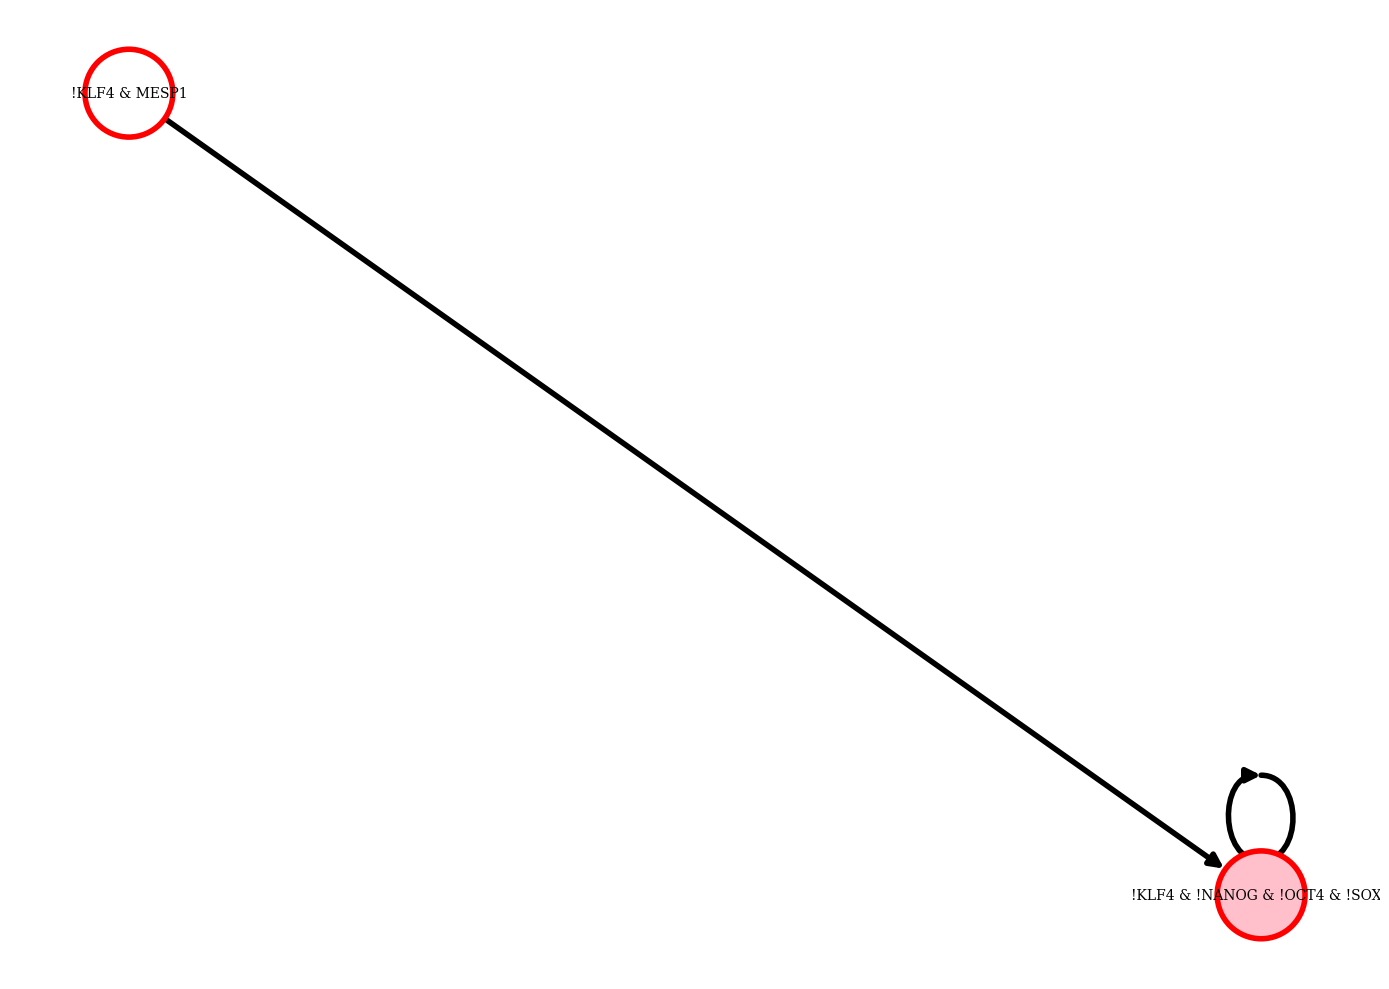

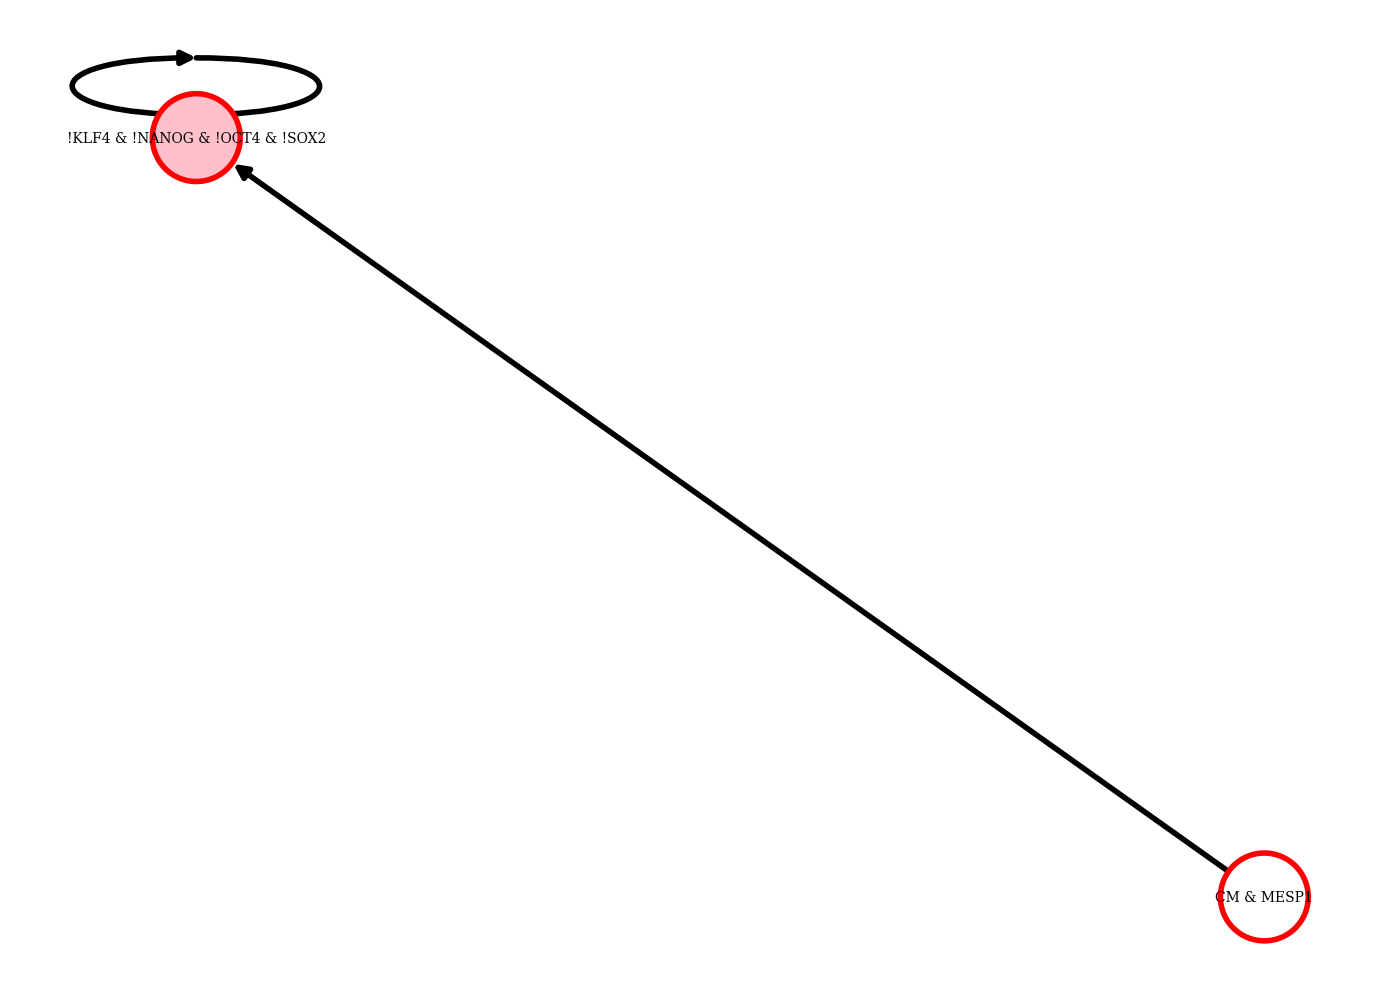

all controllers        : [['!KLF4', '!NANOG', '!OCT4', '!SOX2'], ['!KLF4', '!Ripply2', 'Brachyury'], ['!KLF4', 'MESP1'], ['!NANOG', '!Ripply2', 'Brachyury', 'ISL1'], ['!NANOG', '!Ripply2', 'MESP1'], ['!Ripply2', 'Brachyury', 'CM'], ['CM', 'MESP1']]
relative heights       : [np.int64(1), np.int64(1)]
min controllers        : [['!KLF4', 'MESP1'], ['CM', 'MESP1']]
min robust controllers : [['!KLF4', 'MESP1'], ['CM', 'MESP1']]
mechanism data         : {'!KLF4 & MESP1': {'graph': <networkx.classes.digraph.DiGraph object at 0x000001F1171183D0>, 'controller -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> target': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)]}, 'CM & MESP1': {'graph': <networkx.classes.digraph.DiGraph object at 0x000001F11719EA30>, 'controller -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> self-driven': [('!KLF4 & !NANOG & !OCT4 & !SOX2', 1)], 'self-driven -> t

In [ ]:
import sys
sys.path.append("src")
import NUDGE             # from src/util.py
from copy import deepcopy
import util, RSC, ensemble, analyze, logic, mechanism
from other_methods import simulate, net
import basin

# Load parameters (same as CLI main() would do)
params = util.load_yaml("../input/params.yaml")

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/cpc_ipsc.bnet"  
params2["target"] = "(!NANOG & !OCT4 & !SOX2 & !KLF4)"
params2["approx"] = False
params2["analysis_order"] = 2
params2["measure_robustness"] = True
params2["find_mechanism"] = True

# 1) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 2) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 3) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 4) Pretty print or use the dict
util.pretty_print(results)

In [26]:
params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/cpc_ipsc.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 1) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 2) Define transient control (names must exist in G.nodeNames)
control = {"MESP1": 1, "CM": 1}  # NOTE: double-check names!

# 3) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 256
  λ=1  basin=192/256  (prob=0.750)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 1, 'CM': 1, 'Y': 1}
  λ=1  basin=64/256  (prob=0.250)
    {'NANOG': 0, 'OCT4': 0, 'SOX2': 0, 'KLF4': 0, 'Brachyury': 0, 'MESP1': 0, 'Ripply2': 1, 'ISL1': 0, 'CM': 0, 'Y': 1}

Pseudo-attractors (with basin sizes), total sims = 256
  λ=1  basin=256/256  (prob=1.000)
    {'Y': 1}


# Figure 5

## GMP to Mast Cell Example

1. Visualizing Network (Figure 5A)

In [23]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="../input/networks/mainExamples/ramirez_gmp.bnet",  # or bnet_text=...
    max_per_row=7,
    max_per_row_output=7,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    osci_seed=42,
    x_gap=5.2, y_gap=3.5,          # grid spacing
    y_merge_threshold=0,           # NEW: merge Y with outputs if outputs count <= this
    use_rounded_box=True,
    node_width=2.3,
    node_height=0.8,   
    fontsize=25,
    output_dir="../output/img/",
    base_name="ramirez_graph_final",
    fontname="DejaVu Sans"
)
art


{'dot': '..\\output\\img\\ramirez_graph_final.dot',
 'png': '..\\output\\img\\ramirez_graph_final.png',
 'svg': '..\\output\\img\\ramirez_graph_final.svg',
 'positions_json': '..\\output\\img\\ramirez_graph_final_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 7,
 'max_per_row_input': None,
 'max_per_row_output': 7,
 'focus_targets': None,
 'focus_max_hops': None,
 'outputs_layout': 'separate',
 'num_nodes_drawn': 30,
 'num_edges_drawn': 84}

2. Analyzing the Controllers (Figure 5C-5D)

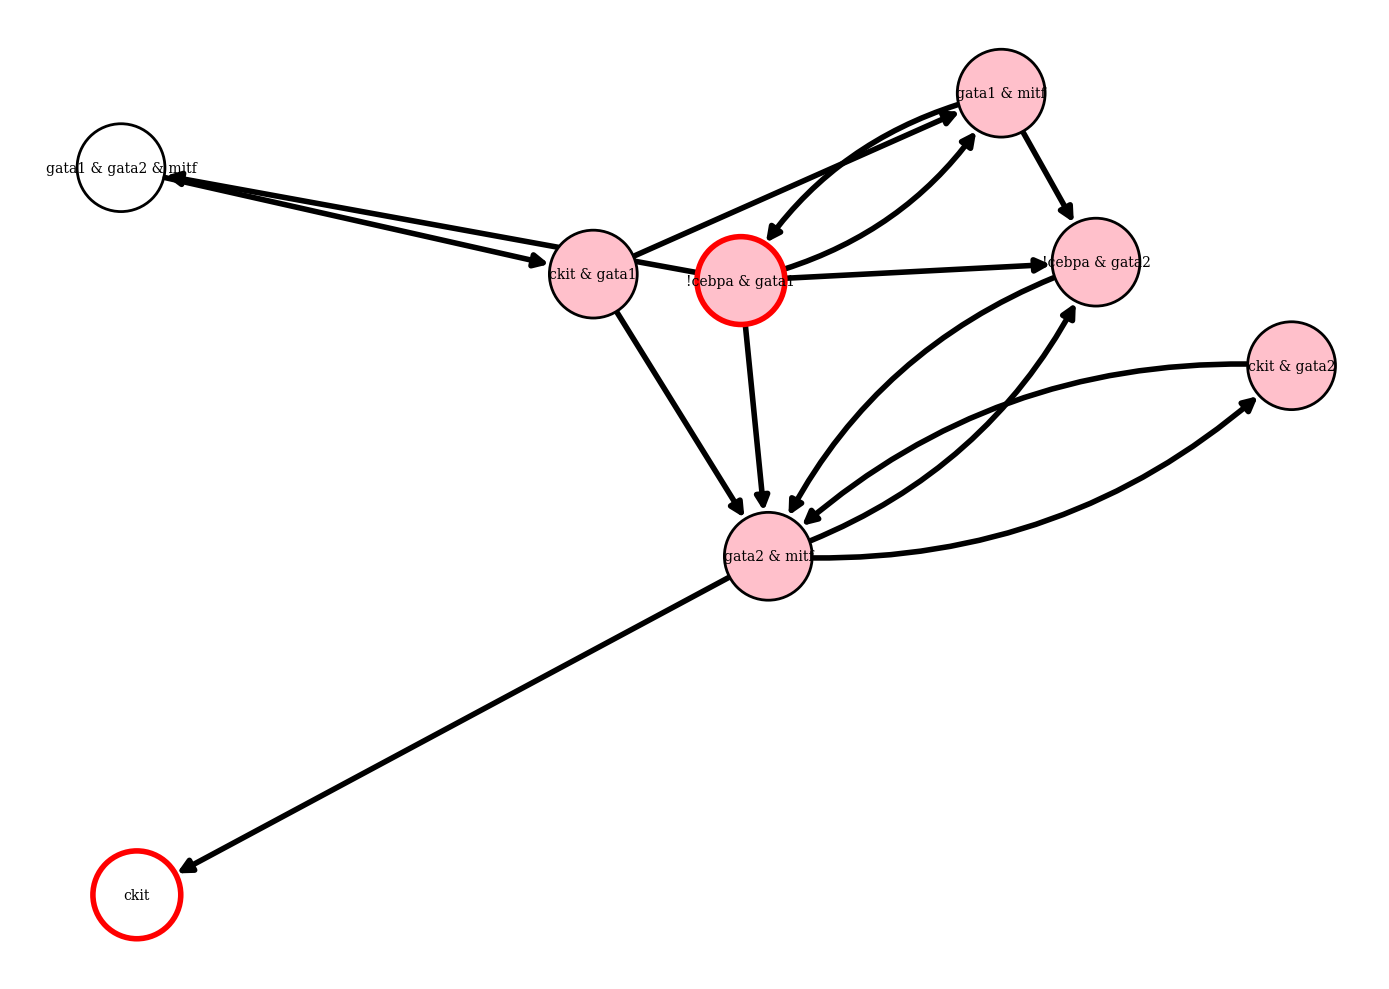

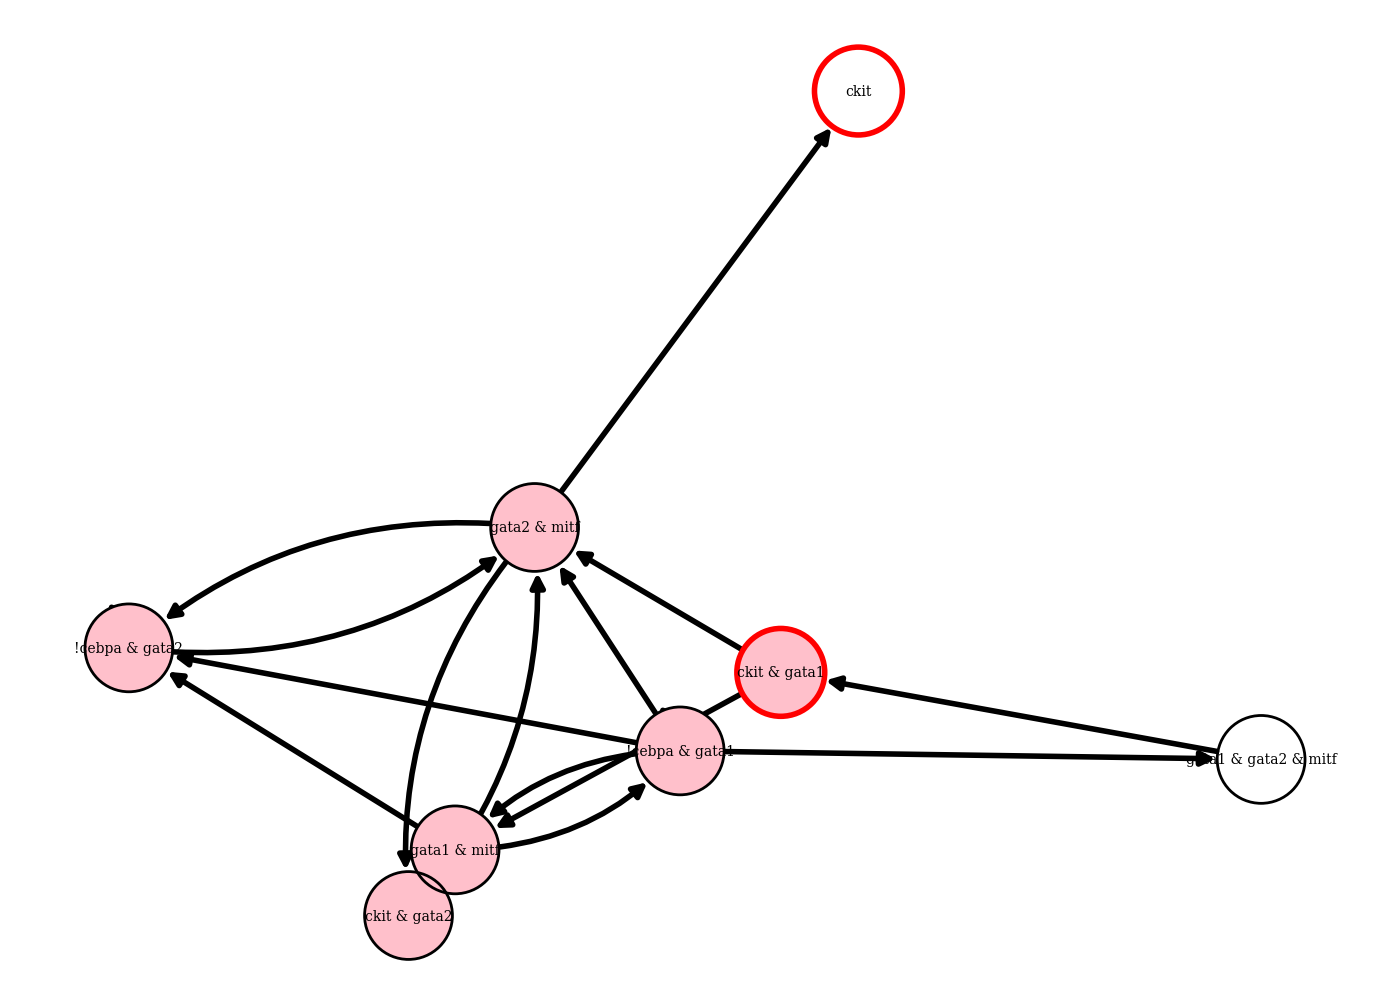

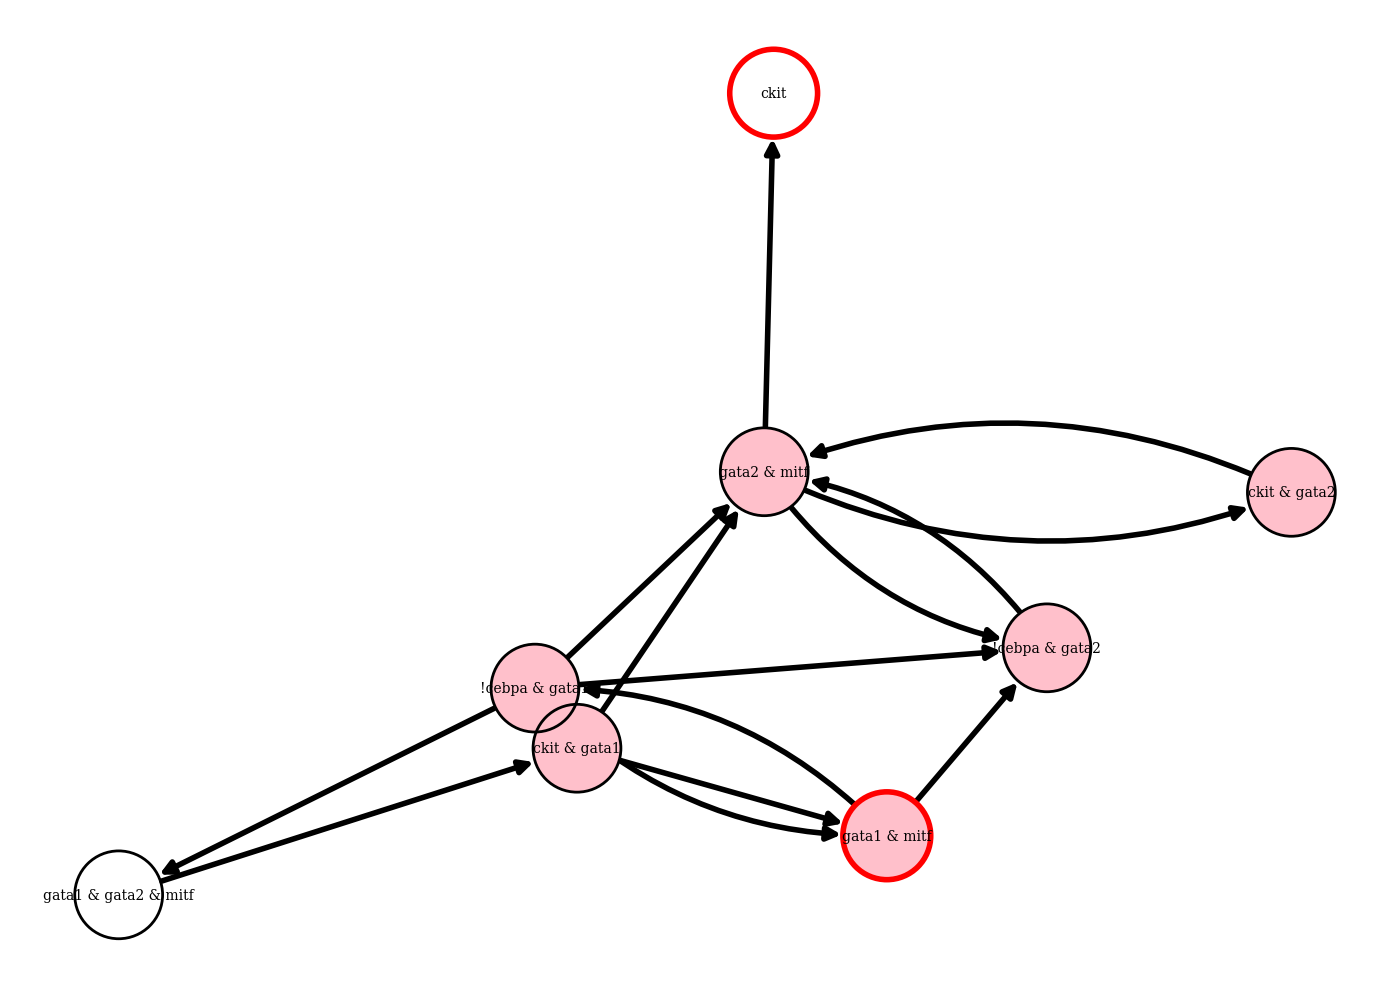

all controllers        : [['!cebpa', 'bc', 'gmcsfr'], ['!cebpa', 'bc', 'il3ra'], ['!cebpa', 'gata1'], ['!cebpa', 'gata2'], ['!cebpa', 'jak2'], ['!cebpa', 'stat5'], ['!mitf', 'cebpa', 'ckit', 'runx1'], ['bc', 'ckit', 'gmcsfr'], ['bc', 'ckit', 'il3ra'], ['bc', 'gmcsfr', 'mitf'], ['bc', 'il3ra', 'mitf'], ['cebpa', 'mitf', 'pu1', 'runx1'], ['ckit', 'gata1'], ['ckit', 'gata2'], ['ckit', 'jak2'], ['ckit', 'stat5'], ['gata1', 'mitf'], ['gata2', 'mitf'], ['jak2', 'mitf'], ['mitf', 'stat5']]
relative heights       : [np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(1)]
min controllers        : [['!cebpa', 'gata1'], ['!cebpa', 'gata2'], ['!cebpa', 'jak2'], ['!cebpa', 'stat5'], ['ckit', 'gata1'], ['ckit', 'gata2'], ['ckit', 'jak2'], ['ckit', 'stat5'], ['gata1', 'mitf'], ['gata2', 'mitf'], ['jak2', 'mitf'], ['mitf', 'stat5']]
min robust controllers : [['!cebpa', 'gata1'], ['ckit', 'gata1'], ['gat

In [28]:
# Load parameters (same as CLI main() would do)
params = util.load_yaml("../input/params.yaml")

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/ramirez_gmp.bnet"  
params2["target"] = "ckit"
params2["approx"] = False
params2["analysis_order"] = 2
params2["measure_robustness"] = True
params2["find_mechanism"] = True

# 1) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 2) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 3) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 4) Pretty print or use the dict
util.pretty_print(results)

In [29]:
params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/ramirez_gmp.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 1) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 2) Define transient control (names must exist in G.nodeNames)
control = {"gata1": 1, "mitf": 1}  # NOTE: double-check names!

# 3) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 4096
  λ=1  basin=1615/4096  (prob=0.394)
    {'cebpa': 0, 'cebpb': 0, 'cjun': 1, 'egr': 1, 'gfi1': 0, 'gata1': 1, 'gata2': 1, 'mitf': 1, 'pu1': 1, 'runx1': 1, 'cmyb': 0, 'scl': 1, 'il3ra': 1, 'stat5': 0, 'jak2': 0, 'bc': 0, 'mcsfr': 0, 'gmcsfr': 1, 'gcsfr': 0, 'ne': 0, 'mpo': 0, 'lf': 0, 'mbp': 0, 'mmcp6': 1, 'mccpa': 1, 'ckit': 1, 'fceRIb': 1, 'fceRIa': 1, 'ccr3': 0, 'Y': 1}
  λ=1  basin=1590/4096  (prob=0.388)
    {'cebpa': 0, 'cebpb': 0, 'cjun': 1, 'egr': 1, 'gfi1': 0, 'gata1': 1, 'gata2': 1, 'mitf': 1, 'pu1': 1, 'runx1': 1, 'cmyb': 0, 'scl': 0, 'il3ra': 1, 'stat5': 0, 'jak2': 0, 'bc': 0, 'mcsfr': 0, 'gmcsfr': 1, 'gcsfr': 0, 'ne': 0, 'mpo': 0, 'lf': 0, 'mbp': 0, 'mmcp6': 1, 'mccpa': 1, 'ckit': 1, 'fceRIb': 1, 'fceRIa': 1, 'ccr3': 0, 'Y': 1}
  λ=1  basin=454/4096  (prob=0.111)
    {'cebpa': 0, 'cebpb': 0, 'cjun': 1, 'egr': 0, 'gfi1': 0, 'gata1': 1, 'gata2': 1, 'mitf': 1, 'pu1': 0, 'runx1': 0, 'cmyb': 1, 'scl': 0, 'il3ra': 1, 'stat5': 

# Figure 6

## Anti-inflammatory Macrophage Example

1. Visualizing Network (Figure 6A)

In [30]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="../input/networks/mainExamples/macrophage.bnet",  # or bnet_text=...
    max_per_row=6,
    max_per_row_output=7,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    osci_seed=42,
    x_gap=5.2, y_gap=3.3,          # grid spacing
    y_merge_threshold=11,           # NEW: merge Y with outputs if outputs count <= this
    use_rounded_box=True,
    node_width=2.3,
    node_height=0.8,   
    fontsize=25,
    output_dir="../output/img/",
    base_name="macro_graph_final",
    fontname="Dejavu Sans",
    bold_labels=True,
)
art


{'dot': '..\\output\\img\\macro_graph_final.dot',
 'png': '..\\output\\img\\macro_graph_final.png',
 'svg': '..\\output\\img\\macro_graph_final.svg',
 'positions_json': '..\\output\\img\\macro_graph_final_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 6,
 'max_per_row_input': None,
 'max_per_row_output': 7,
 'focus_targets': None,
 'focus_max_hops': None,
 'outputs_layout': 'separate',
 'num_nodes_drawn': 31,
 'num_edges_drawn': 58}

2. Analyzing the Controllers (Figure 6C)

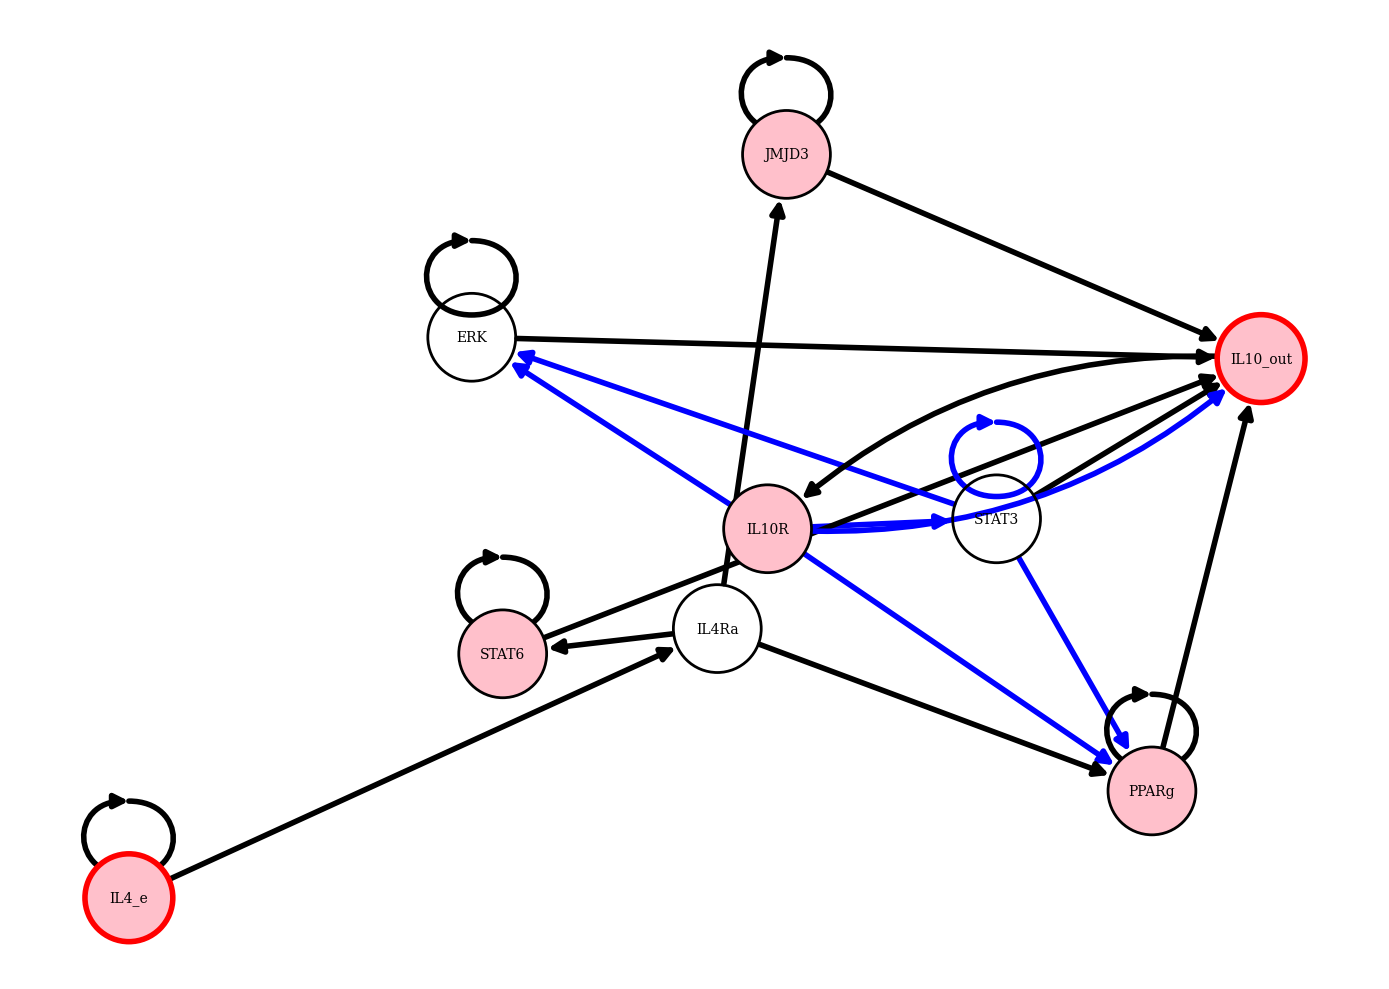

all controllers        : [['ERK'], ['FcgR'], ['IC_e', 'LPS_e'], ['IL10R'], ['IL10_e'], ['IL10_out'], ['IL4Ra'], ['IL4_e'], ['JMJD3'], ['PPARg'], ['STAT3'], ['STAT6']]
relative heights       : [np.int64(4), np.int64(4), np.int64(3), np.int64(4), np.int64(3), np.int64(5), np.int64(6), np.int64(4), np.int64(3), np.int64(3), np.int64(4)]
min controllers        : [['ERK'], ['FcgR'], ['IL10R'], ['IL10_e'], ['IL10_out'], ['IL4Ra'], ['IL4_e'], ['JMJD3'], ['PPARg'], ['STAT3'], ['STAT6']]
min robust controllers : [['IL4_e']]
mechanism data         : {'IL4_e': {'graph': <networkx.classes.digraph.DiGraph object at 0x000001F12A67CDF0>, 'controller -> self-driven': [('IL10R', 1), ('IL10_out', 1), ('IL4_e', 1), ('JMJD3', 1), ('PPARg', 1), ('STAT6', 1)], 'self-driven -> self-driven': [('IL10R', 3), ('IL10_out', 3), ('IL4_e', 1), ('JMJD3', 1), ('PPARg', 1), ('STAT6', 1)], 'self-driven -> target': [('IL10R', 3), ('IL10_out', 3), ('IL4_e', 1), ('JMJD3', 3), ('PPARg', 3), ('STAT6', 3)]}}
best controllers 

In [ ]:
import sys
sys.path.append("src")
import util, RSC, ensemble, analyze, logic, mechanism
from copy import deepcopy
from other_methods import simulate, net
import basin

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/macrophage.bnet"  
params2["target"] = "IL10_out"
params2["approx"] = False
params2["analysis_order"] = 3
params2["measure_robustness"] = True
params2["find_mechanism"] = True

# 1) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 2) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 3) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 4) Pretty print or use the dict
util.pretty_print(results)

In [32]:
params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "../input/networks/mainExamples/macrophage.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 1) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 2) Define transient control (names must exist in G.nodeNames)
control = {"IL4_e": 1}  # NOTE: double-check names!

# 3) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=["Y"]      # also double-check names exist
)

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 4096
  λ=1  basin=76/4096  (prob=0.019)
    {'IFNgR': 1, 'CSF2Ra': 0, 'IL1R': 0, 'TLR4': 0, 'FcgR': 1, 'IL4Ra': 1, 'IL10R': 1, 'STAT1': 0, 'STAT5': 0, 'NF_kB': 0, 'PPARg': 1, 'STAT6': 1, 'JMJD3': 1, 'STAT3': 0, 'IRF3': 0, 'ERK': 1, 'KLF4': 1, 'SOCS1': 1, 'IRF4': 1, 'IL1b': 0, 'IFNb': 0, 'IL12_out': 0, 'IL10_out': 1, 'IFNg_e': 1, 'GM_CSF_e': 0, 'IL1b_e': 0, 'LPS_e': 1, 'IC_e': 1, 'IL4_e': 1, 'IL10_e': 0, 'Y': 1}
  λ=1  basin=73/4096  (prob=0.018)
    {'IFNgR': 0, 'CSF2Ra': 1, 'IL1R': 0, 'TLR4': 0, 'FcgR': 1, 'IL4Ra': 1, 'IL10R': 1, 'STAT1': 0, 'STAT5': 0, 'NF_kB': 0, 'PPARg': 1, 'STAT6': 1, 'JMJD3': 1, 'STAT3': 0, 'IRF3': 0, 'ERK': 1, 'KLF4': 1, 'SOCS1': 1, 'IRF4': 1, 'IL1b': 0, 'IFNb': 0, 'IL12_out': 0, 'IL10_out': 1, 'IFNg_e': 0, 'GM_CSF_e': 1, 'IL1b_e': 0, 'LPS_e': 1, 'IC_e': 1, 'IL4_e': 1, 'IL10_e': 0, 'Y': 1}
  λ=1  basin=72/4096  (prob=0.018)
    {'IFNgR': 1, 'CSF2Ra': 0, 'IL1R': 0, 'TLR4': 0, 'FcgR': 1, 'IL4Ra': 1, 'IL10R': 1, 'STA